This notebook investigates fairness and bias in face recognition using the DeepFace model, focusing on compliance with the EU AI Act. We analyze the model's performance across demographic groups (age, gender, race) using the FairFace dataset and AIF360 toolkit. The workflow includes:

1. **Data Preparation:** Load and preprocess FairFace data (sample size: 50).
2. **Model Evaluation:** Use DeepFace to predict age, gender, and race. Map predictions to required categories.
3. **Fairness Analysis:** Calculate metrics.
4. **Visualization:** Plot disparities before and after mitigation.
5. **Mitigation Strategies:** Apply bias mitigation and re-evaluate fairness.

Demographic categories:
- **Race:** 0-5 (6 groups): ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]
- **Gender:** 0 (male), 1 (female)
- **Age:** 0-8 (9 groups: ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"])

In [1]:
# Install required packages and import libraries
!pip install deepface aif360 datasets scikit-learn pandas matplotlib --quiet

import os
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from deepface import DeepFace
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import random

/home/jannis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 22:30:10.558423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[inFairness]'


In [2]:
# Load FairFace dataset (sample size: 50, only necessary columns)
dataset = load_dataset('HuggingFaceM4/FairFace', '0.25')
df = dataset['train']  # Use the dataset directly

# Select only relevant columns to reduce memory usage
columns_needed = ['image', 'age', 'gender', 'race']
df = df.remove_columns([col for col in df.column_names if col not in columns_needed])

# Sample 50 rows for analysis
sample_df = df.shuffle(seed=42).select(range(200))

# Convert to pandas DataFrame for easier processing
sample_df = pd.DataFrame(sample_df)

# Age group mapping for later use with predictions
age_bins = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]
gender_map = {'Man': 0, 'Woman': 1, 'male': 0, 'female': 1}
race_bins = ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]
def get_lower_bound(age_bin):
    if '-' in age_bin:
        return int(age_bin.split('-')[0])
    elif 'more than' in age_bin:
        return 70
    else:
        return 0
def get_upper_bound(age_bin):
    if '-' in age_bin:
        return int(age_bin.split('-')[1])
    elif 'more than' in age_bin:
        return 70
    else:
        return 0
def map_deepface_race(race_str):
    if race_str is None:
        return None
    race_str = race_str.lower()
    if race_str == 'asian':
        return 'East Asian'
    if race_str == 'southeast asian':
        return 'Southeast Asian'
    if race_str == 'indian':
        return 'Indian'
    if race_str == 'black':
        return 'Black'
    if race_str == 'white':
        return 'White'
    if race_str == 'middle eastern':
        return 'Middle Eastern'
    if race_str == 'latino hispanic':
        return 'Latino_Hispanic'
    return None
def map_age(age_str):
    return age_bins.index(age_str) if age_str in age_bins else 8

sample_df.head()

,image,age,gender,race
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,1,6
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,0,5
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,0,6
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4,1,3
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,1,6


In [3]:
# Prepare images and sample for DeepFace analysis
from PIL import Image
import numpy as np
#sample = dataset['train'].shuffle(seed=42).select(range(50))
images = [np.array(img.convert("RGB")) if isinstance(img, Image.Image) else np.array(Image.fromarray(img)) for img in sample_df['image']]
print(f'Number of images for prediction: {len(images)}')

Number of images for prediction: 200


In [4]:
# Predict age, gender, and race using DeepFace
pred_ages, pred_genders, pred_races = [], [], []
gender_probs_list, race_probs_list = [], []
for i, img in enumerate(images):
    try:
        #print(f'Predicting image {i}...')
        result = DeepFace.analyze(img, actions=['age', 'gender', 'race'], enforce_detection=False)
        #print(f'Result for image {i}:', result)
        if isinstance(result, list):
            result = result[0]
        # Age: map to group index (0-8)
        for j, a in enumerate(age_bins):
            if result['age'] <= get_upper_bound(a): 
                pred_age_group = j
                break
        pred_ages.append(pred_age_group)
        # Gender: map to 0/1 (use dominant_gender for DeepFace)
        pred_gender = gender_map.get(result.get('dominant_gender', None), None)
        pred_genders.append(pred_gender)
        # Race: map to FairFace categories
        dominant_race = result.get('dominant_race', None)
        mapped_race = map_deepface_race(dominant_race)
        pred_race = race_bins.index(mapped_race) if isinstance(mapped_race, str) and mapped_race in race_bins else None
        pred_races.append(pred_race)
        # Save gender probabilities
        gender_probs = {gender_map.get(k, None): v for k, v in result.get('gender', {}).items() if gender_map.get(k, None) is not None}
        gender_probs_list.append(gender_probs)
        # Save race probabilities
        race_probs = {race_bins.index(map_deepface_race(k)): v for k, v in result.get('race', {}).items() if map_deepface_race(k) in race_bins}
        race_probs_list.append(race_probs)
    except Exception as e:
        print(f'Error at image {i}:', e)
        pred_ages.append(None)
        pred_genders.append(None)
        pred_races.append(None)
        gender_probs_list.append({g: 0.5 for g in gender_map.values()})
        race_probs_list.append({r: 1/len(race_bins) for r in range(len(race_bins))})


Action: age:   0%|          | 0/3 [00:00<?, ?it/s]    2025-09-29 22:30:17.269455: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-09-29 22:30:17.269455: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Action: race: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


In [5]:
# Build DataFrame for analysis
import pandas as pd
print('First 20 pred_ages:', pred_ages[:20])
print('First 20 pred_genders:', pred_genders[:20])
print('First 20 pred_races:', pred_races[:20])
print('Length pred_ages:', len(pred_ages))
print('Length images:', len(images))

min_len = min(len(sample_df['age']), len(sample_df['gender']), len(sample_df['race']), len(pred_ages), len(pred_genders), len(pred_races))
print('Minimum length for all columns:', min_len)

result_df = pd.DataFrame({
    'age': list(sample_df['age'])[:min_len],
    'gender': list(sample_df['gender'])[:min_len],
    'race': list(sample_df['race'])[:min_len],
    'pred_age': pred_ages[:min_len],
    'pred_gender': pred_genders[:min_len],
    'pred_race': pred_races[:min_len],
    'gender_probs': gender_probs_list[:min_len],
    'race_probs': race_probs_list[:min_len]
})

result_df.dropna(inplace=True)
print('Resulting DataFrame shape:', result_df.shape)
print(result_df.head())

First 20 pred_ages: [3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 3, 5, 4, 4, 3, 3, 3, 3, 5, 4]
First 20 pred_genders: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
First 20 pred_races: [0, 5, 0, 3, 0, 0, 0, 0, 4, 0, 2, 5, 0, 0, 0, 3, 1, 1, 0, 3]
Length pred_ages: 200
Length images: 200
Minimum length for all columns: 200
Resulting DataFrame shape: (200, 8)
   age  gender  race  pred_age  pred_gender  pred_race  \
0    3       1     6         3            0          0   
1    3       0     5         3            0          5   
2    2       0     6         4            0          0   
3    4       1     3         4            1          3   
4    2       1     6         4            0          0   

                                     gender_probs  \
0   {1: 0.5356122739613056, 0: 99.46439266204834}   
1  {1: 0.001166353376902407, 0: 99.9988317489624}   
2   {1: 0.28784272726625204, 0: 99.7121512889862}   
3    {1: 99.7080385684967, 0: 0.2919560531154275}   
4    {1: 18.15113723278045

Age metrics: {0: {'accuracy': 0.0}, 1: {'accuracy': 0.0}, 2: {'accuracy': 0.0}, 3: {'accuracy': 0.43103448275862066}, 4: {'accuracy': 0.6274509803921569}, 5: {'accuracy': 0.13636363636363635}, 6: {'accuracy': 0.0625}, 7: {'accuracy': 0.0}, 8: {'accuracy': 0.0}}
Gender metrics: {0: {'accuracy': 0.9732142857142857}, 1: {'accuracy': 0.4318181818181818}}
Race metrics: {0: {'accuracy': 0.8518518518518519}, 1: {'accuracy': 0.4375}, 2: {'accuracy': 0.9}, 3: {'accuracy': 0.9444444444444444}, 4: {'accuracy': 0.7222222222222222}, 5: {'accuracy': 0.34375}, 6: {'accuracy': 0.0}}


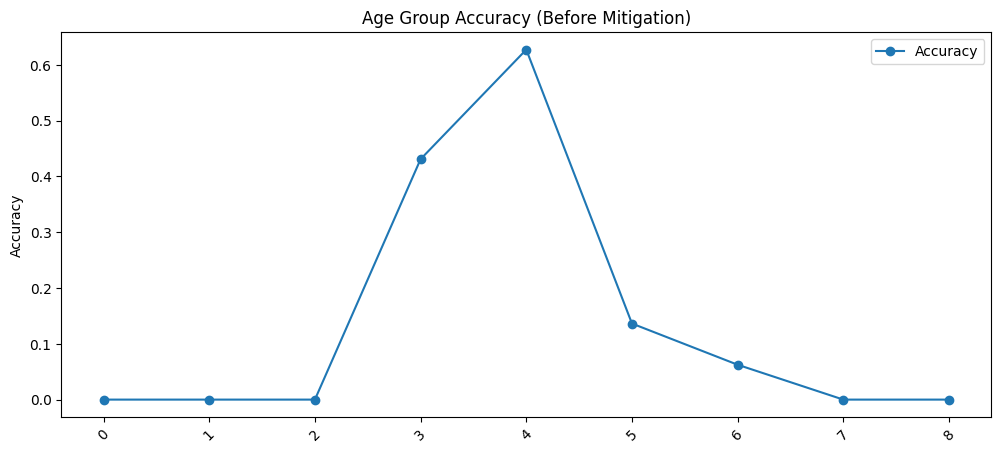

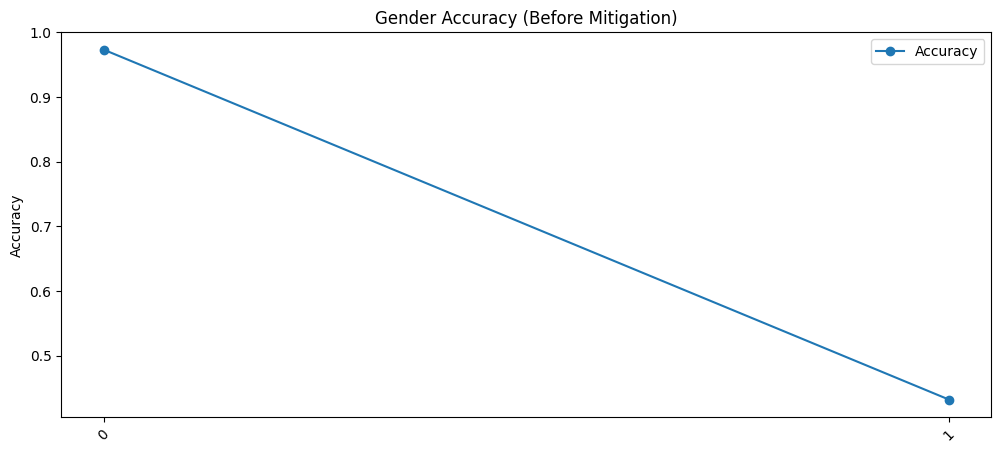

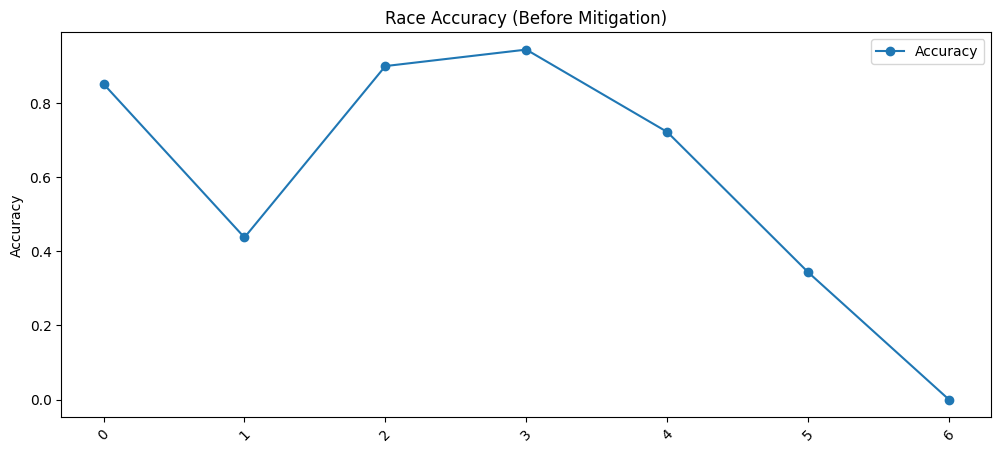

In [6]:
# Fairness and Bias Evaluation with AIF360
import numpy as np
from sklearn.metrics import accuracy_score

def get_metrics(df, label_col, pred_col, group_col, all_groups):
    metrics = {}
    for group in all_groups:
        group_df = df[df[group_col] == group]
        if len(group_df) == 0:
            metrics[group] = {'accuracy': None}
            continue
        # Accuracy for this group
        acc = accuracy_score(group_df[label_col], group_df[pred_col])
        metrics[group] = {'accuracy': acc}
    return metrics

age_groups = list(range(9))
gender_groups = [0, 1]
race_groups = list(range(7))

age_metrics = get_metrics(result_df, 'age', 'pred_age', 'age', age_groups)
gender_metrics = get_metrics(result_df, 'gender', 'pred_gender', 'gender', gender_groups)
race_metrics = get_metrics(result_df, 'race', 'pred_race', 'race', race_groups)

print('Age metrics:', age_metrics)
print('Gender metrics:', gender_metrics)
print('Race metrics:', race_metrics)

import matplotlib.pyplot as plt

def plot_group_metrics(metrics, title, group_labels):
    acc = [metrics[g]['accuracy'] if metrics[g]['accuracy'] is not None else 0 for g in group_labels]
    x = range(len(group_labels))
    plt.figure(figsize=(12,5))
    plt.plot(x, acc, label='Accuracy', marker='o')
    plt.xticks(x, group_labels, rotation=45)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_group_metrics(age_metrics, 'Age Group Accuracy (Before Mitigation)', age_groups)
plot_group_metrics(gender_metrics, 'Gender Accuracy (Before Mitigation)', gender_groups)
plot_group_metrics(race_metrics, 'Race Accuracy (Before Mitigation)', race_groups)


   age  gender  race  pred_age  pred_gender  pred_race  \
0    3       1     6         3            0          0   
1    3       0     5         3            0          5   
2    2       0     6         4            0          0   
3    4       1     3         4            1          3   
4    2       1     6         4            0          0   

                                     gender_probs  \
0   {1: 0.5356122739613056, 0: 99.46439266204834}   
1  {1: 0.001166353376902407, 0: 99.9988317489624}   
2   {1: 0.28784272726625204, 0: 99.7121512889862}   
3    {1: 99.7080385684967, 0: 0.2919560531154275}   
4    {1: 18.151137232780457, 0: 81.8488597869873}   

                                          race_probs  
0  {0: 48.45408797264099, 1: 8.40747281908989, 2:...  
1  {0: 1.4635148458182812, 1: 7.406432181596756, ...  
2  {0: 99.99014139175415, 1: 0.000782155348133528...  
3  {0: 0.0029941220384196478, 1: 0.00618187660178...  
4  {0: 99.17078614234924, 1: 0.01853073772508651,...  
Cl

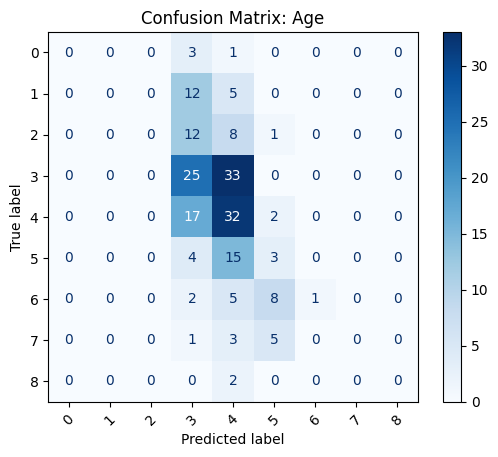

Classification report for Gender:
              precision    recall  f1-score   support

           0       0.69      0.97      0.80       112
           1       0.93      0.43      0.59        88

    accuracy                           0.73       200
   macro avg       0.81      0.70      0.70       200
weighted avg       0.79      0.73      0.71       200

              precision    recall  f1-score   support

           0       0.69      0.97      0.80       112
           1       0.93      0.43      0.59        88

    accuracy                           0.73       200
   macro avg       0.81      0.70      0.70       200
weighted avg       0.79      0.73      0.71       200



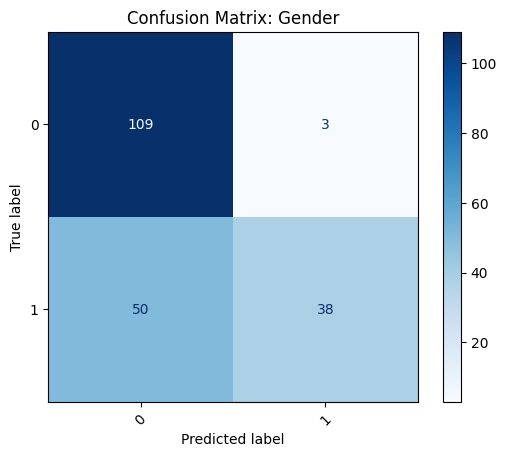

Classification report for Race:
              precision    recall  f1-score   support

           0       0.38      0.85      0.53        27
           1       1.00      0.44      0.61        32
           2       0.90      0.90      0.90        30
           3       0.62      0.94      0.75        36
           4       0.65      0.72      0.68        18
           5       0.52      0.34      0.42        32
           6       0.00      0.00      0.00        25

    accuracy                           0.61       200
   macro avg       0.58      0.60      0.55       200
weighted avg       0.60      0.61      0.57       200



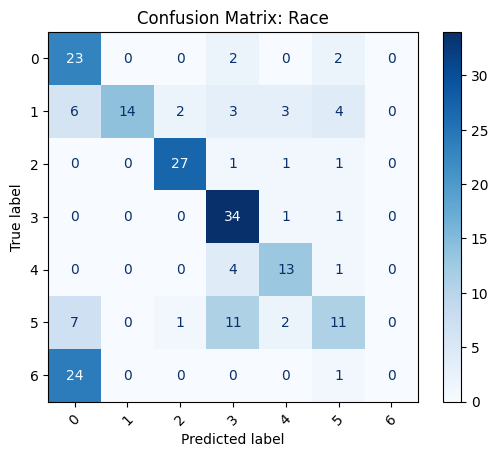

In [7]:
# Multiclass metrics for fairness analysis
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(result_df.head())

def multiclass_metrics(y_true, y_pred, labels, title):
    print(f'Classification report for {title}:')
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Age metrics (multiclass)
multiclass_metrics(result_df["age"], result_df["pred_age"], list(range(9)), 'Age')
# Gender metrics (binary, but use multiclass report for consistency)
multiclass_metrics(result_df["gender"], result_df['pred_gender'], [0, 1], 'Gender')
# Race metrics (multiclass)
multiclass_metrics(result_df['race'], result_df['pred_race'], list(range(7)), 'Race')

Low accuracy gender classes: {1: 0.4318181818181818}
Low accuracy race classes: {1: 0.4375, 5: 0.34375, 6: 0.0}

--- Mitigation Debug (first 5 examples) ---
Index: 0
Gender probs before: {1: 0.5356122739613056, 0: 99.46439266204834}
Gender probs after:  {1: 0.015067687604675578, 0: 0.9849323123953244}
Pred gender before: 0, after: 0
Race probs before: {0: 48.45408797264099, 1: 8.40747281908989, 2: 3.384247049689293, 3: 5.329106003046036, 4: 1.4924703165888786, 5: 32.932618260383606}
Race probs after:  {0: 0.25453109810333774, 1: 0.12421339461547964, 2: 0.017777573654812646, 3: 0.02799398894124856, 4: 0.00784000121480974, 5: 0.5676439434703117}
Pred race before: 0, after: 5
---
Index: 1
Gender probs before: {1: 0.001166353376902407, 0: 99.9988317489624}
Gender probs after:  {1: 3.313432830141547e-05, 0: 0.9999668656716986}
Pred gender before: 0, after: 0
Race probs before: {0: 1.4635148458182812, 1: 7.406432181596756, 2: 0.5902712699025869, 3: 14.948977530002594, 4: 11.826826632022858, 

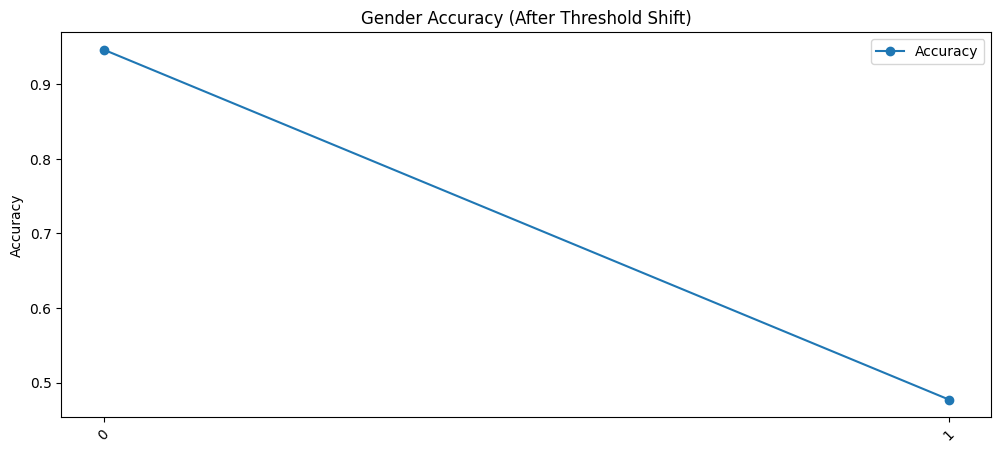

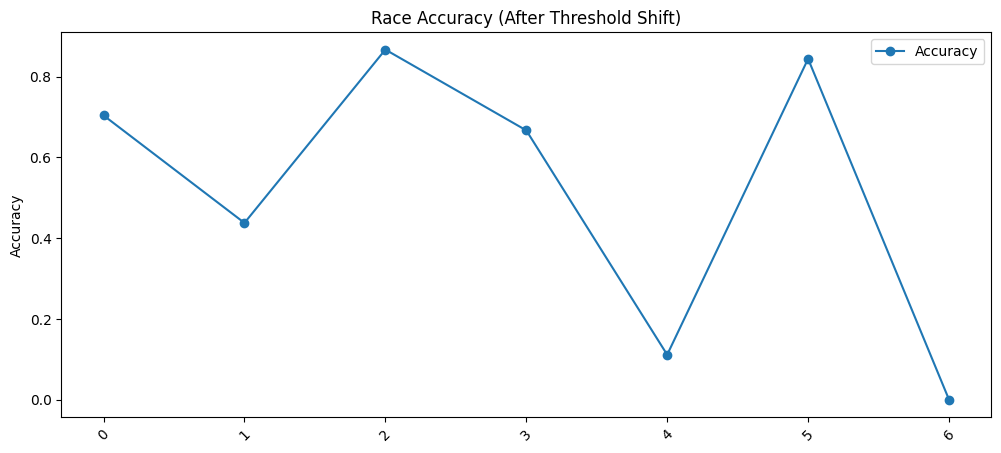

In [9]:
# Mitigation: Threshold shifting based on probabilities
import copy
np.random.seed(42)

# Step 1: Identify gender and race classes with low accuracy (<0.7)
low_acc_gender = {g: m['accuracy'] for g, m in gender_metrics.items() if m['accuracy'] is not None and m['accuracy'] < 0.7}
low_acc_race = {g: m['accuracy'] for g, m in race_metrics.items() if m['accuracy'] is not None and m['accuracy'] < 0.7}
print('Low accuracy gender classes:', low_acc_gender)
print('Low accuracy race classes:', low_acc_race)

# Step 2: Adjust probabilities and set new prediction
factor = 5  # Moderate boost factor
mitigated_df = copy.deepcopy(result_df)

debug_rows = []  # For debug output

for idx, row in mitigated_df.iterrows():
    # Gender
    gender_probs = row['gender_probs']
    adj_gender_probs = gender_probs.copy()
    for k in low_acc_gender:
        if k in adj_gender_probs:
            boost = factor * (1 - low_acc_gender[k])
            adj_gender_probs[k] *= boost
    # Normalize
    total = sum(adj_gender_probs.values())
    for k in adj_gender_probs:
        adj_gender_probs[k] /= total
    # Set new prediction to class with highest probability
    old_pred_gender = row['pred_gender']
    new_pred_gender = max(adj_gender_probs, key=adj_gender_probs.get)
    mitigated_df.at[idx, 'pred_gender'] = new_pred_gender
    # Race
    race_probs = row['race_probs']
    adj_race_probs = race_probs.copy()
    for k in low_acc_race:
        if k in adj_race_probs:
            boost = factor * (1 - low_acc_race[k])
            adj_race_probs[k] *= boost
    total = sum(adj_race_probs.values())
    for k in adj_race_probs:
        adj_race_probs[k] /= total
    old_pred_race = row['pred_race']
    new_pred_race = max(adj_race_probs, key=adj_race_probs.get)
    mitigated_df.at[idx, 'pred_race'] = new_pred_race
    # Debug: Save old and new probabilities and predictions for the first 5 examples
    if len(debug_rows) < 5:
        debug_rows.append({
            'idx': idx,
            'gender_probs_before': gender_probs,
            'gender_probs_after': adj_gender_probs,
            'pred_gender_before': old_pred_gender,
            'pred_gender_after': new_pred_gender,
            'race_probs_before': race_probs,
            'race_probs_after': adj_race_probs,
            'pred_race_before': old_pred_race,
            'pred_race_after': new_pred_race
        })

# Debug output for the first 5 examples
print('\n--- Mitigation Debug (first 5 examples) ---')
for row in debug_rows:
    print(f"Index: {row['idx']}")
    print(f"Gender probs before: {row['gender_probs_before']}")
    print(f"Gender probs after:  {row['gender_probs_after']}")
    print(f"Pred gender before: {row['pred_gender_before']}, after: {row['pred_gender_after']}")
    print(f"Race probs before: {row['race_probs_before']}")
    print(f"Race probs after:  {row['race_probs_after']}")
    print(f"Pred race before: {row['pred_race_before']}, after: {row['pred_race_after']}")
    print('---')

# Step 3: Calculate new metrics
mitigated_gender_metrics = get_metrics(mitigated_df, 'gender', 'pred_gender', 'gender', gender_groups)
mitigated_race_metrics = get_metrics(mitigated_df, 'race', 'pred_race', 'race', race_groups)

print('Mitigated Gender metrics (threshold shift):', mitigated_gender_metrics)
print('Mitigated Race metrics (threshold shift):', mitigated_race_metrics)

plot_group_metrics(mitigated_gender_metrics, 'Gender Accuracy (After Threshold Shift)', gender_groups)
plot_group_metrics(mitigated_race_metrics, 'Race Accuracy (After Threshold Shift)', race_groups)
